In [113]:
import numpy as np
from scipy.integrate import solve_bvp
from scipy.integrate._bvp import BVPResult
from matplotlib import pyplot as plt

from typing import List, Tuple, Callable

from matplotlib import animation

from scipy.special import ellipe

In [114]:
class Planet:
    """Model a planet."""
    
    YEAR_TO_SEC = 31536000
    
    def __init__(
        self,name: str,
        mass: float,
        R1: float,
        R2: float,
        velocity: float,
        radius: float = 0,
        t0=0
    ):
        """Construct a planet, setting its properties and calculating angular velocity of ships on the surface.

        Args:
            name (str): _description_
            mass (float): Mass in units of kg
            R1 (float): Major axis length, units of m
            R2 (float): Minor axis length, units of m
            velocity (float): Speed, units of m/s
            radius (float, optional): _description_. Defaults to 0.
            t0 (int, optional): How far along this is into orbit. units of earth years. Defaults to 0.
        """        
        #Initialize parameters
        self.mass = mass
        self.t0 = t0
        self.R1 = R1
        self.R2 = R2
        self.velocity = velocity
        self.name = name
        self.radius = radius
        #Calculate circumference of ellipse:
        #calculate the circumference of the ellipse using scipy special ellipse integral
        eccentricity_squared = 1-(R2**2)/(R1**2)
        Circumference = 4*R1*ellipe(eccentricity_squared)
        #calculate angular velocity given circumference of orbit, velocity:
        # print(Circumference)
        #(m/s)/m = /s, /s *2*pi = radians/s = ω, angular frequency/velocity
        #So we need 2π*velocity/circumference
        self.omega = 2*np.pi*velocity/Circumference #omega is in units of radians/second

    def position(self,t):
        """
        Even though our units are specified in seconds, we probably want t here to be years
        t = time, units of years, subject to change
        """
        return np.array([self.px(t), self.py(t)])
    
    def px(self,t):
        """
        Even though our units are specified in seconds, we probably want t here to be years
        t = time, units of years, subject to change
        """
        t_new = t + self.YEAR_TO_SEC*self.t0#add in current + initial time
        # t_new = self.YEAR_TO_SEC*t_new#convert from years to seconds
        return self.R1*np.cos(self.omega*t_new)
    
    def py(self,t):
        """
        Even though our units are specified in seconds, we probably want t here to be years
        t = time, units of years, subject to change

        Returns position in km
        """
        t_new = t + self.YEAR_TO_SEC*self.t0#add in current + initial time
        # t_new = self.YEAR_TO_SEC*t_new#convert from years to seconds
        return self.R2*np.sin(self.omega*t_new)
    
    def velocity_vector(self,t):
        """
        t = units of time
        Returns velocity in km/s

        """
        t_new = t + self.t0#add in current + initial time
        t_new = self.YEAR_TO_SEC*t_new#convert from years to seconds
        # (31536000+21600)*t_new
        #calculate unit vector in dir of velocity
        # unit_vector = np.array([-self.R1*np.sin(self.omega*t_new),self.R2*np.cos(self.omega*t_new)])
        # unit_vector = unit_vector/np.linalg.norm(unit_vector)
        # return unit_vector*self.velocity
        return self.omega*np.array([-self.R1*np.sin(self.omega*t_new),self.R2*np.cos(self.omega*t_new)])
    
    def plot_orbit(self,t0,t1):
        t_span = np.linspace(t0,t1,250)
        positions = self.position(t_span)
        plt.plot(positions[0,:],positions[1,:],label = self.name)
        plt.xlabel("x position (m)")
        plt.ylabel("y position (m)")
        plt.legend()
#test velocity:
# Earth = Planet(name='Earth',mass=5.9722e24,R1=147.1e9,R2=152.1e9,velocity = 29.78e3,t0=0)
# v1 = Earth.velocity_vector(0)
# print(v1)
# print(np.linalg.norm(v1))
# v2 = Earth.velocity_vector(.123)
# print(np.linalg.norm(v2))
# v1 = Earth.velocity_vector(.25)
# print(np.linalg.norm(v1))
# test = np.array([1,2])
# a,b = test
# print(a,b)

In [115]:
YEAR_TO_SEC = 31536000

def best_path(
    planets: List[Planet],
    T: float,
    figname: str | None = None,
    animname: str | None = None,
    N_COMPUTE_STEPS: int = 10000,
    N_ANIM_FRAMES: int = 50,
    ANIM_LEN_SEC: float = 3,
    max_nodes: int = 100000,
    G: float = -6.674e-11,
) -> BVPResult:
    """Solve a boundary value problem to get from planet 0 to planet 1. Graph and animate results.

    Args:
        planets (List[PlanetType]): List of planets. Must have at least 2.
        T (float): Final time.
        figname (str | None, optional): If str, save a figure to this path. Defaults to None.
        animname (str | None, optional): If str, save an animation to this path. Defaults to None.
        N_COMPUTE_STEPS (int, optional): Number of time steps to use. Defaults to 10000.
        N_ANIM_FRAMES (int, optional): Number of frames in the animation total. Defaults to 50.
        ANIM_LEN_SEC (float, optional): Duration of the animation. Defaults to 3.
        max_nodes (int, optional): Max nodes for BVP solver. 1000 ends too quickly.
        G (float, optional): Gravitational constant. Defaults to 6.674e-11.
    Returns:
        BVPResult: Result of solving the BVP.
    """

    # this stores a list of planets with each planet's mass and position with [mass, pos_x, pos_y]

    def norm(sx, sy, px, py):
        return ((sx-px)**2 + (sy-py)**2)**(1/2)
    

    M = 0.
    
    def ode(t, y):
        '''
        sx: spaceship x position
        sy: spaceship y position
        dsx: spaceship x velocity
        dsy: spaceship y velocity
        fuel: fuel at time t
        p1, p2, p3, p4: costate vars
            '''
        
        sx, sy = y[0], y[1]
        dsx, dsy = y[2], y[3]
        p1, p2, p3, p4 = y[4], y[5], y[6], y[7]

        # ddsx = G * sum([mp*(sx-px(t))/(norm(sx, sy, px(t), py(t)))**3 for mp, px, py in planets] + p3/2)
        # ddsy = G * sum([mp*(sy-py(t))/(norm(sx, sy, px(t), py(t)))**3 for mp, px, py in planets] + p4/2)

        # dp1 = -p3*(G * sum([mp/norm(sx, sy, px(t), py(t))**3 - 3*mp*(sx - px(t))**2/norm(sx, sy, px(t), py(t))**5 for mp, px, py in planets]))
        # dp2 = -p4*(G * sum([mp/norm(sx, sy, px(t), py(t))**3 - 3*mp*(sy - py(t))**2/norm(sx, sy, px(t), py(t))**5 for mp, px, py in planets]))
        
        ddsx = 0
        ddsy = 0
        dp1 = 0
        dp2 = 0
        
        for planet in planets:
            dist = norm(sx, sy, planet.px(t), planet.py(t))
            dist3 = dist**3
            dist5 = dist**5
            dx = sx - planet.px(t)
            dy = sy - planet.py(t)
            
            ddsx += planet.mass*dx/dist3
            ddsy += planet.mass*dy/dist3

            dp1 += planet.mass/dist3 - 3*planet.mass*dx**2/dist5
            dp2 += planet.mass/dist3 - 3*planet.mass*dy**2/dist5

        ddsx = G * ddsx + p3/2
        ddsy = G * ddsx + p4/2
        
        dp1 = -p3*G*dp1
        dp2 = -p4*G*dp2
        
        dp3 = -p1 + M*dsx
        dp4 = -p2 + M*dsy

        return np.array([dsx, dsy, ddsx, ddsy, dp1, dp2, dp3, dp4])

    #Position BCs
    #add in the radius of the planet
    target_start_x = planets[0].px(0) + planets[0].radius
    target_start_y = planets[0].py(0)
    target_end_x = planets[1].px(T*YEAR_TO_SEC)+ planets[1].radius
    target_end_y = planets[1].py(T*YEAR_TO_SEC)
    #Velocity BCs
    velocity_start_x,velocity_start_y = planets[0].velocity_vector(0)
    velocity_end_x,velocity_end_y = planets[1].velocity_vector(T*YEAR_TO_SEC)
    # print(velocity_start_x,velocity_start_y,velocity_end_x,velocity_end_y,)
    
    # target_start_x = planets[0].px(0)
    # target_start_y = planet.
    # target_end_x = planets[1][1](T)
    # target_end_y = planets[1][2](T)
    def bc(ya, yb):
        return np.array([
            # Start at first planet x, y, with velocity matching the initial planet
            ya[0] - target_start_x,
            ya[1] - target_start_y,
            ya[2] - velocity_start_x,
            ya[3] - velocity_start_y,
            
            # End at second planet's x/y, with velocity matching the final planet
            yb[0] - target_end_x,
            yb[1] - target_end_y,
            yb[2] - velocity_end_x,
            yb[3] - velocity_end_y,
        ])

    t = np.linspace(0, T*YEAR_TO_SEC, N_COMPUTE_STEPS)
    y_guess = np.zeros((8, t.size))
    y_guess[0:2,0] = [target_start_x, target_start_y]
    y_guess[0:2,-1] = [target_end_x, target_end_y]

    print("Running solve_bvp...")
    soln = solve_bvp(ode, bc, t, y_guess, verbose=2, max_nodes=max_nodes)

    sx = soln.sol(t)[0]
    sy = soln.sol(t)[1]
    vx = soln.sol(t)[2]
    vy = soln.sol(t)[3]
    speed = np.sqrt(vx**2+vy**2)
    
    ux = soln.sol(t)[6]/2
    uy = soln.sol(t)[7]/2

    fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw={"height_ratios": [2, 1]})
    
    #????????????????????????????????????????????????????????????????????????????????????
    masses = [planet.mass for planet in planets]
    min_mass = min(masses)
    max_mass = max(masses)
    min_radius = 5
    max_radius = 12
    def mass_to_radius(mass):
        return min_radius + (mass - min_mass) / (max_mass - min_mass+0.1) * (max_radius - min_radius)
    #????????????????????????????????????????????????????????????????????????????????????
    planet_x_ts = []
    planet_y_ts = []
    planet_trajectories = []
    planet_points = []

    #WE COULD USE THE PLANET CLASS PRE-BUILT PLOTTING TO DO THIS PROBABLY
    for i, planet in enumerate(planets):
        pxt = planet.px(t)
        pyt = planet.py(t)
        planet_x_ts.append(pxt)
        planet_y_ts.append(pyt)
        color = next(ax1._get_lines.prop_cycler)['color']
        planet_trajectories.append(ax1.plot(pxt, pyt, label=f'{planet.name}', color=color)[0])
        
        
        
        planet_points.append(ax1.plot(pxt[-1], pyt[-1], "o", color=color, markersize=mass_to_radius(planet.mass))[0])
    
    control_x_graph, = ax2.plot(t, ux, label='control in x direction')
    control_y_graph, = ax2.plot(t, uy, label='control in y direction')

    color = next(ax1._get_lines.prop_cycler)['color']

    ss_point, = ax1.plot(sx[-1], sy[-1], "o", color=color)
    ss_trajectory_plot, = ax1.plot(sx, sy, color=color, label='Optimal Path')
    
    ax1.set(xlabel="x", ylabel="y", title="Optimal Path")
    ax1.legend(loc="center left", bbox_to_anchor=(1, 0.5, 0.3, 0.3), bbox_transform=ax1.transAxes)
    ax2.set(title='Optimal Control', xlabel="Time", ylabel="Acceleration")
    ax2.legend(loc="center left", bbox_to_anchor=(1, 0.5, 0.3, 0.3), bbox_transform=ax2.transAxes)
    fig.tight_layout()
    fig.show()
    # Save Figure if applicable
    if figname:
        fig.savefig(figname, dpi=300)
        print(f"Figure saved to {figname}")
    def plot_velocity():
        plt.figure()
        plt.plot(t,speed)
        plt.show()
    plot_velocity()
    # Animation
    def update_anim(anim_frame):
        
        i = min(N_COMPUTE_STEPS-1, int((anim_frame+1) / N_ANIM_FRAMES * N_COMPUTE_STEPS))
        
        # update spaceship graph
        ss_trajectory_plot.set_xdata(sx[:i+1])
        ss_trajectory_plot.set_ydata(sy[:i+1])
        # update spaceship dot
        ss_point.set_xdata(sx[i])
        ss_point.set_ydata(sy[i])
        
        # update planets
        for j, _ in enumerate(planets):
            planet_trajectories[j].set_xdata(planet_x_ts[j][:i+1])
            planet_trajectories[j].set_ydata(planet_y_ts[j][:i+1])
            
            planet_points[j].set_xdata(planet_x_ts[j][i])
            planet_points[j].set_ydata(planet_y_ts[j][i])
        
        # update control expenditure
        control_x_graph.set_xdata(t[:i+1])
        control_x_graph.set_ydata(ux[:i+1])
        
        control_y_graph.set_xdata(t[:i+1])
        control_y_graph.set_ydata(uy[:i+1])
        
    # Run and Save Animation if applicable
    if animname: 
        print("Saving animation...")   
        anim = animation.FuncAnimation(fig, update_anim, range(N_ANIM_FRAMES), interval=ANIM_LEN_SEC * 1000 // N_ANIM_FRAMES)
        anim.save(animname,dpi=300)
        print(f"Animation saved to {animname}")

    plt.close()
    
    

Running solve_bvp...
   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          2.32e+03       1.89e+03         10000            4       
       2          5.87e+02       1.18e+02         10004           12       
       3          5.63e+02       6.37e+01         10016           228      
       4          3.67e+00       1.97e-11         10244           89       
       5          5.31e+00       7.21e-12         10333           228      
       6          3.62e+01       7.63e-06         10561           597      
       7          8.40e+00       3.05e-05         11158          1431      
       8          3.69e+01       3.05e-05         12589          3489      
       9          4.55e+01       3.05e-05         16078          8747      
      10          2.22e+02       6.10e-05         24825         (22631)    
Number of nodes is exceeded after iteration 10. 
Maximum relative residual: 2.22e+02 
Maximum boundary residual: 6.10e-05


/var/folders/9b/7hhd76216mg0g_995zr6rb_c0000gn/T/ipykernel_15666/494416118.py:176: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Figure saved to Earth_Mars_test_newG_M_4.png


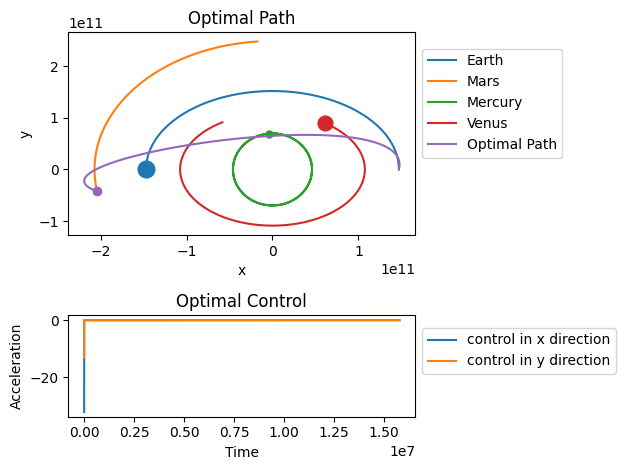

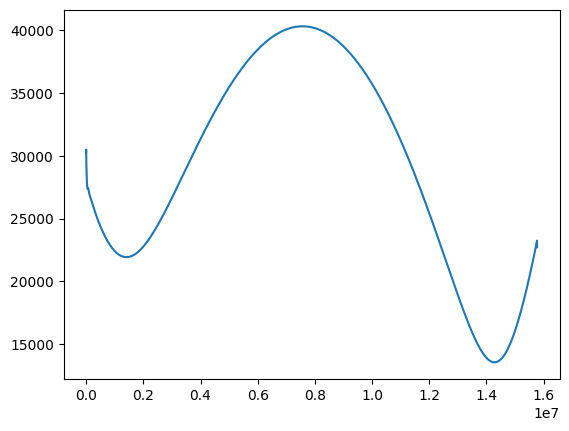

Saving animation...
Animation saved to Earth_Mars_test_newG_M_4.mp4


In [116]:
#Test it with the planets class:
best_path(
    inner_planets:= [
        Planet(name='Earth',mass=5.9722e24,R1=147.1e9,R2=152.1e9,velocity = 29.78e3,t0=0,radius=6378e3),
        Planet(name='Mars',mass=6.39e23,R1=207e9,R2=249e9,velocity = 24e3,t0=.5,radius=3390e3),
        Planet(name='Mercury',mass=3.285e23,R1=46e9,R2=69.82e9,velocity = 47.36e3,t0=.55,radius=2440e3),
        Planet(name='Venus',mass=4.8675e24,R1=107.48e9,R2=108.94e9,velocity = 35.02e3,t0=0.21,radius=6051e3),
    ],
    0.5, 
    figname='Earth_Mars_test_newG_M_4.png',
    animname="Earth_Mars_test_newG_M_4.mp4",
    max_nodes=30000,
    G=-6.674e-11,
)

In [117]:
YEAR_TO_SEC = 31536000

def best_path_tf(
    planets: List[Planet],
    p0: float,
    y_guess: np.ndarray,
    figname: str | None = None,
    animname: str | None = None,
    N_COMPUTE_STEPS: int = 10000,
    N_ANIM_FRAMES: int = 50,
    ANIM_LEN_SEC: float = 3,
    max_nodes: int = 100000,
    G: float = -6.674e-11,
) -> BVPResult:
    """Solve a boundary value problem to get from planet 0 to planet 1. Graph and animate results.

    Args:
        planets (List[PlanetType]): List of planets. Must have at least 2.
        T (float): Final time.
        figname (str | None, optional): If str, save a figure to this path. Defaults to None.
        animname (str | None, optional): If str, save an animation to this path. Defaults to None.
        N_COMPUTE_STEPS (int, optional): Number of time steps to use. Defaults to 10000.
        N_ANIM_FRAMES (int, optional): Number of frames in the animation total. Defaults to 50.
        ANIM_LEN_SEC (float, optional): Duration of the animation. Defaults to 3.
        max_nodes (int, optional): Max nodes for BVP solver. 1000 ends too quickly.
        G (float, optional): Gravitational constant. Defaults to 6.674e-11.
    Returns:
        BVPResult: Result of solving the BVP.
    """

    # this stores a list of planets with each planet's mass and position with [mass, pos_x, pos_y]

    def norm(sx, sy, px, py):
        return ((sx-px)**2 + (sy-py)**2)**(1/2)
    

    M = 0
    
    def ode(t, y, p):
        '''
        sx: spaceship x position
        sy: spaceship y position
        dsx: spaceship x velocity
        dsy: spaceship y velocity
        fuel: fuel at time t
        p1, p2, p3, p4: costate vars
            '''
        tf = p[0]
        sx, sy = y[0], y[1]
        dsx, dsy = y[2], y[3]
        p1, p2, p3, p4 = y[4], y[5], y[6], y[7]

        # ddsx = G * sum([mp*(sx-px(t))/(norm(sx, sy, px(t), py(t)))**3 for mp, px, py in planets] + p3/2)
        # ddsy = G * sum([mp*(sy-py(t))/(norm(sx, sy, px(t), py(t)))**3 for mp, px, py in planets] + p4/2)

        # dp1 = -p3*(G * sum([mp/norm(sx, sy, px(t), py(t))**3 - 3*mp*(sx - px(t))**2/norm(sx, sy, px(t), py(t))**5 for mp, px, py in planets]))
        # dp2 = -p4*(G * sum([mp/norm(sx, sy, px(t), py(t))**3 - 3*mp*(sy - py(t))**2/norm(sx, sy, px(t), py(t))**5 for mp, px, py in planets]))
        
        ddsx = 0
        ddsy = 0
        dp1 = 0
        dp2 = 0
        
        for planet in planets:
            dist = norm(sx, sy, planet.px(t*tf), planet.py(t*tf))
            dist3 = dist**3
            dist5 = dist**5
            dx = sx - planet.px(t*tf)
            dy = sy - planet.py(t*tf)
            
            ddsx += planet.mass*dx/dist3
            ddsy += planet.mass*dy/dist3

            dp1 += planet.mass/dist3 - 3*planet.mass*dx**2/dist5
            dp2 += planet.mass/dist3 - 3*planet.mass*dy**2/dist5

        ddsx = G * ddsx + p3/2
        ddsy = G * ddsx + p4/2
        
        dp1 = -p3*G*dp1
        dp2 = -p4*G*dp2
        
        dp3 = -p1 + M*dsx
        dp4 = -p2 + M*dsy

        return tf*np.array([dsx, dsy, ddsx, ddsy, dp1, dp2, dp3, dp4])

    #Position BCs
    #add in the radius of the planet
    target_start_x = planets[0].px(0) + planets[0].radius
    target_start_y = planets[0].py(0)
    # target_end_x = planets[1].px(0)+ planets[1].radius
    # target_end_y = planets[1].py(T*YEAR_TO_SEC)
    #Velocity BCs
    velocity_start_x,velocity_start_y = planets[0].velocity_vector(0)
    # velocity_end_x,velocity_end_y = planets[1].velocity_vector(1)
    # print(velocity_start_x,velocity_start_y,velocity_end_x,velocity_end_y,)
    
    # target_start_x = planets[0].px(0)
    # target_start_y = planet.
    # target_end_x = planets[1][1](T)
    # target_end_y = planets[1][2](T)
    def bc(ya, yb, p):
        tf = p[0]
        sx, sy = yb[0], yb[1]
        dsx, dsy = yb[2], yb[3]
        p1, p2, p3, p4 = yb[4], yb[5], yb[6], yb[7]
        ddsx = 0
        ddsy = 0
        for planet in planets:
            dist = norm(sx, sy, planet.px(tf), planet.py(tf))
            dist3 = dist**3
            dx = sx - planet.px(tf)
            dy = sy - planet.py(tf)
            
            ddsx += planet.mass*dx/dist3
            ddsy += planet.mass*dy/dist3

        h = p1*dsx + p2*dsy + p3*(G*ddsx + p3/2) + p4*(G*ddsy+p4/2) - (p3/2)**2 - (p4/2)**2

        target_end_y = planets[1].py(tf)
        target_end_x = planets[1].px(tf)+ planets[1].radius
        velocity_end_x, velocity_end_y = planets[1].velocity_vector(tf)
        
        return np.array([
            # Start at first planet x, y, with velocity matching the initial planet
            ya[0] - target_start_x,
            ya[1] - target_start_y,
            ya[2] - velocity_start_x,
            ya[3] - velocity_start_y,

            # End at second planet's x/y, with velocity matching the final planet
            yb[0] - target_end_x,
            yb[1] - target_end_y,
            yb[2] - velocity_end_x,
            yb[3] - velocity_end_y,
            h
        ])

    t = np.linspace(0, 1, N_COMPUTE_STEPS)
    # y_guess[0:2,0] = [target_start_x, target_start_y]
    # y_guess[0:2,-1] = [target_end_x, target_end_y]

    print("Running solve_bvp...")
    soln = solve_bvp(ode, bc, t, y_guess, p=np.array([p0*YEAR_TO_SEC]), verbose=2, max_nodes=max_nodes)
    tf = soln.p[0]
     
    sx = soln.sol(t)[0]
    sy = soln.sol(t)[1]
    vx = soln.sol(t)[2]
    vy = soln.sol(t)[3]
    speed = np.sqrt(vx**2+vy**2)
    
    ux = soln.sol(t)[6]/2
    uy = soln.sol(t)[7]/2

    fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw={"height_ratios": [2, 1]})
    
    #????????????????????????????????????????????????????????????????????????????????????
    masses = [planet.mass for planet in planets]
    min_mass = min(masses)
    max_mass = max(masses)
    min_radius = 5
    max_radius = 12
    def mass_to_radius(mass):
        return min_radius + (mass - min_mass) / (max_mass - min_mass+0.1) * (max_radius - min_radius)
    #????????????????????????????????????????????????????????????????????????????????????
    planet_x_ts = []
    planet_y_ts = []
    planet_trajectories = []
    planet_points = []

    #WE COULD USE THE PLANET CLASS PRE-BUILT PLOTTING TO DO THIS PROBABLY
    for i, planet in enumerate(planets):
        pxt = planet.px(t*tf)
        pyt = planet.py(t*tf)
        planet_x_ts.append(pxt)
        planet_y_ts.append(pyt)
        color = next(ax1._get_lines.prop_cycler)['color']
        planet_trajectories.append(ax1.plot(pxt, pyt, label=f'{planet.name}', color=color)[0])
        
        
        
        planet_points.append(ax1.plot(pxt[-1], pyt[-1], "o", color=color, markersize=mass_to_radius(planet.mass))[0])
    
    control_x_graph, = ax2.plot(t, ux, label='control in x direction')
    control_y_graph, = ax2.plot(t, uy, label='control in y direction')

    color = next(ax1._get_lines.prop_cycler)['color']

    ss_point, = ax1.plot(sx[-1], sy[-1], "o", color=color)
    ss_trajectory_plot, = ax1.plot(sx, sy, color=color, label='Optimal Path')
    
    ax1.set(xlabel="x", ylabel="y", title="Optimal Path")
    ax1.legend(loc="center left", bbox_to_anchor=(1, 0.5, 0.3, 0.3), bbox_transform=ax1.transAxes)
    ax2.set(title='Optimal Control', xlabel="Time", ylabel="Acceleration")
    ax2.legend(loc="center left", bbox_to_anchor=(1, 0.5, 0.3, 0.3), bbox_transform=ax2.transAxes)
    fig.tight_layout()
    fig.show()
    # Save Figure if applicable
    if figname:
        fig.savefig(figname, dpi=300)
        print(f"Figure saved to {figname}")
    def plot_velocity():
        plt.figure()
        plt.plot(t,speed)
        plt.show()
    plot_velocity()
    # Animation
    def update_anim(anim_frame):
        
        i = min(N_COMPUTE_STEPS-1, int((anim_frame+1) / N_ANIM_FRAMES * N_COMPUTE_STEPS))
        
        # update spaceship graph
        ss_trajectory_plot.set_xdata(sx[:i+1])
        ss_trajectory_plot.set_ydata(sy[:i+1])
        # update spaceship dot
        ss_point.set_xdata(sx[i])
        ss_point.set_ydata(sy[i])
        
        # update planets
        for j, _ in enumerate(planets):
            planet_trajectories[j].set_xdata(planet_x_ts[j][:i+1])
            planet_trajectories[j].set_ydata(planet_y_ts[j][:i+1])
            
            planet_points[j].set_xdata(planet_x_ts[j][i])
            planet_points[j].set_ydata(planet_y_ts[j][i])
        
        # update control expenditure
        control_x_graph.set_xdata(t[:i+1])
        control_x_graph.set_ydata(ux[:i+1])
        
        control_y_graph.set_xdata(t[:i+1])
        control_y_graph.set_ydata(uy[:i+1])
        
    # Run and Save Animation if applicable
    if animname: 
        print("Saving animation...")   
        anim = animation.FuncAnimation(fig, update_anim, range(N_ANIM_FRAMES), interval=ANIM_LEN_SEC * 1000 // N_ANIM_FRAMES)
        anim.save(animname,dpi=300)
        print(f"Animation saved to {animname}")

    plt.close()

    return tf/YEAR_TO_SEC, t, soln
    
    

Running solve_bvp...
   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          5.38e+02       4.57e+04         10000          10030     
       2          1.18e+02       1.39e+04         20030          3321      
       3          9.67e+03       1.75e+04         23351         (10274)    
Number of nodes is exceeded after iteration 3. 
Maximum relative residual: 9.67e+03 
Maximum boundary residual: 1.75e+04
Figure saved to Earth_Mars_tf.png


/var/folders/9b/7hhd76216mg0g_995zr6rb_c0000gn/T/ipykernel_15666/1833931978.py:199: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


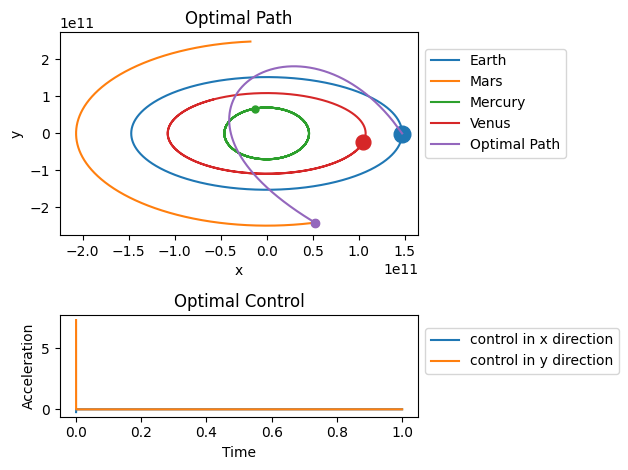

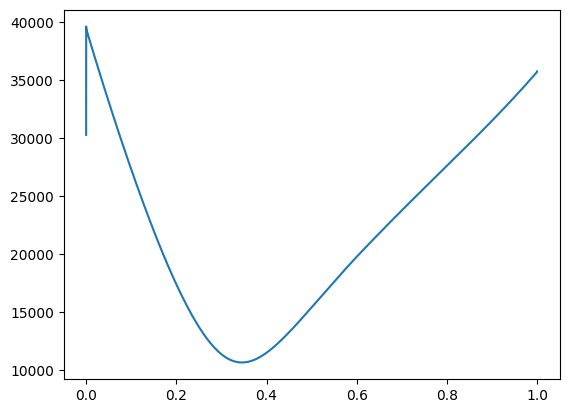

Saving animation...
Animation saved to Earth_Mars_tf.mp4


(0.9999999658013337,
 array([0.00000000e+00, 1.00010001e-04, 2.00020002e-04, ...,
        9.99799980e-01, 9.99899990e-01, 1.00000000e+00]),
        message: The maximum number of mesh nodes is exceeded.
        success: False
         status: 1
              x: [ 0.000e+00  1.111e-05 ...  1.000e+00  1.000e+00]
            sol: <scipy.interpolate._interpolate.PPoly object at 0x144aa9b20>
              p: [ 3.154e+07]
              y: [[ 1.471e+11  1.471e+11 ...  5.250e+10  5.251e+10]
                  [ 0.000e+00  1.109e+07 ... -2.408e+11 -2.409e+11]
                  ...
                  [-4.581e-01 -1.885e-01 ...  4.580e-03  4.774e-03]
                  [ 1.460e+01  1.528e+01 ... -6.311e-04 -1.008e-03]]
             yp: [[ 0.000e+00 -1.394e+11 ...  6.332e+11  6.289e+11]
                  [ 9.548e+11  1.037e+12 ... -9.357e+11 -9.357e+11]
                  ...
                  [ 3.030e+04  1.677e+04 ...  9.711e+00  2.432e+01]
                  [ 2.750e+05 -9.668e+04 ... -3.603e+01 -1.

In [118]:
#Test it with the planets class:
best_path_tf(
    inner_planets,
    1, 
    y_guess = np.ones((8, 10000))*50000,
    figname='Earth_Mars_tf.png',
    animname="Earth_Mars_tf.mp4",
    max_nodes=30000,
    N_COMPUTE_STEPS=10000,
    G=-6.674e-11,
)